## Chapter 16 Machine Learning Asset Allocation

In [100]:
import numbers
import numpy as np
import scipy as sc
import pandas as pd
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import matplotlib
import matplotlib.pyplot as plt
from mlfinlab.portfolio_optimization.cla import CLA
from mlfinlab.portfolio_optimization.hrp import HierarchicalRiskParity
from mlfinlab.portfolio_optimization.mean_variance import MeanVarianceOptimisation
import seaborn as sns

%matplotlib inline
np.random.seed(42)

## Getting the Data

In [87]:
stock_prices = pd.read_csv('../Sample-Data/stock_prices.csv', parse_dates = True, index_col = 'date')
stock_prices = stock_prices.dropna(axis = 1)

In [88]:
stock_prices.head()

,AAPL,GE,AMD,WMT,BAC,T,XOM,BBY,PFE,JPM
date,,,,,,,,,,
1989-12-29,0.117203,0.352438,3.9375,3.486070,1.752478,2.365775,1.766756,0.166287,0.110818,1.827968
1990-01-02,0.123853,0.364733,4.1250,3.660858,1.766686,2.398184,1.766756,0.173216,0.113209,1.835617
1990-01-03,0.124684,0.364050,4.0000,3.660858,1.780897,2.356516,1.749088,0.194001,0.113608,1.896803
1990-01-04,0.125100,0.362001,3.9375,3.641439,1.743005,2.403821,1.731422,0.190537,0.115402,1.904452
1990-01-05,0.125516,0.358586,3.8125,3.602595,1.705114,2.287973,1.722587,0.190537,0.114405,1.912100


To calculate the returns, we need to re-index the dataframe on the "date" column

In [89]:
stock_returns = stock_prices.pct_change().dropna(how = 'all')
stock_returns.head()

,AAPL,GE,AMD,WMT,BAC,T,XOM,BBY,PFE,JPM
date,,,,,,,,,,
1990-01-02,0.056739,0.034886,0.047619,0.050139,0.008107,0.013699,0.000000,0.041669,0.021576,0.004184
1990-01-03,0.006710,-0.001873,-0.030303,0.000000,0.008044,-0.017375,-0.010000,0.119995,0.003524,0.033333
1990-01-04,0.003336,-0.005628,-0.015625,-0.005304,-0.021277,0.020074,-0.010100,-0.017856,0.015791,0.004033
1990-01-05,0.003325,-0.009434,-0.031746,-0.010667,-0.021739,-0.048193,-0.005103,0.000000,-0.008639,0.004016
1990-01-08,0.006621,0.005714,0.000000,0.013477,0.005555,0.016877,0.015384,-0.072726,-0.008706,0.000000


The pct_change() function calculates the percentage change with the previous day price for each asset. This is basically the returns for that asset on different time periods

## Question-16.1

### Given the PnL series on N investment strategies:
### (a) Align them to the average frequency of their bets (e.g., weekly observations for strategies that trade on a weekly basis). Hint: This kind of data alignment is sometimes called “downsampling.”

We have these 10 investment strategies with their PnL returns on each day starting from 1989-12-29. Lets resample them to create weekly observations (downsampling).

In [90]:
stock_returns_downsampled = stock_returns.resample('W').mean()

In [6]:
stock_returns_downsampled.head()

,AAPL,GE,AMD,WMT,BAC,T,XOM,BBY,PFE,JPM
date,,,,,,,,,,
1990-01-07,0.017528,0.004488,-0.007514,0.008542,-0.006716,-0.007949,-0.006301,0.035952,0.008063,0.011391
1990-01-14,-0.017620,-0.007657,-0.003120,-0.008005,-0.010128,-0.011023,-0.004009,-0.026548,-0.008051,-0.011397
1990-01-21,-0.000800,0.005535,0.000947,-0.004454,0.007278,0.000173,0.003710,0.016493,0.004702,-0.004270
1990-01-28,-0.008673,-0.007310,-0.003111,-0.006317,-0.005619,-0.011277,-0.007677,0.012255,-0.007884,-0.016935
1990-02-04,0.009076,-0.002387,-0.010286,-0.000546,-0.000193,0.005659,0.004793,0.007340,0.004785,-0.002684


Earlier, we had the returns for an asset for each day. Using the above code snippet, we calculate the mean returns in a week and resample the dataframe to show returns on a weekly basis.

### (b) Compute the covariance of their returns, V

In [7]:
V = stock_returns_downsampled.cov()

In [8]:
V

,AAPL,GE,AMD,WMT,BAC,T,XOM,BBY,PFE,JPM
AAPL,0.000155,0.000026,0.000075,0.000020,0.000029,0.000011,0.000012,0.000046,0.000010,0.000029
GE,0.000026,0.000067,0.000042,0.000021,0.000053,0.000019,0.000017,0.000030,0.000021,0.000047
AMD,0.000075,0.000042,0.000320,0.000019,0.000061,0.000023,0.000019,0.000066,0.000024,0.000060
WMT,0.000020,0.000021,0.000019,0.000052,0.000022,0.000014,0.000011,0.000031,0.000018,0.000022
BAC,0.000029,0.000053,0.000061,0.000022,0.000146,0.000023,0.000020,0.000044,0.000026,0.000094
T,0.000011,0.000019,0.000023,0.000014,0.000023,0.000051,0.000013,0.000014,0.000014,0.000023
XOM,0.000012,0.000017,0.000019,0.000011,0.000020,0.000013,0.000035,0.000010,0.000017,0.000019
BBY,0.000046,0.000030,0.000066,0.000031,0.000044,0.000014,0.000010,0.000226,0.000016,0.000048
PFE,0.000010,0.000021,0.000024,0.000018,0.000026,0.000014,0.000017,0.000016,0.000066,0.000024
JPM,0.000029,0.000047,0.000060,0.000022,0.000094,0.000023,0.000019,0.000048,0.000024,0.000117


### (c) Identify the hierarchical clusters among the N strategies

In [9]:
correlation = stock_returns_downsampled.corr()
distances = np.sqrt((1 - correlation) / 2)
clusters = linkage(squareform(distances), method = "single")
clusters

array([[ 4.        ,  9.        ,  0.37188815,  2.        ],
       [ 1.        , 10.        ,  0.4824748 ,  3.        ],
       [ 6.        , 11.        ,  0.568792  ,  4.        ],
       [ 3.        , 12.        ,  0.56963574,  5.        ],
       [ 8.        , 13.        ,  0.57246838,  6.        ],
       [ 0.        ,  2.        ,  0.57600585,  2.        ],
       [ 5.        , 14.        ,  0.58445669,  7.        ],
       [15.        , 16.        ,  0.58635485,  9.        ],
       [ 7.        , 17.        ,  0.59256394, 10.        ]])

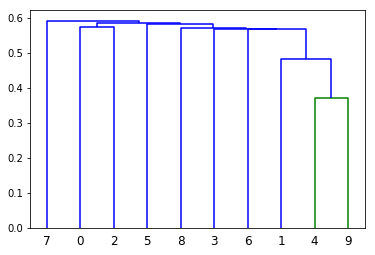

In [10]:
dendrogram(clusters)
plt.show()

### (d) Plot the clustered correlation matrix of the N strategies

<Figure size 504x504 with 0 Axes>

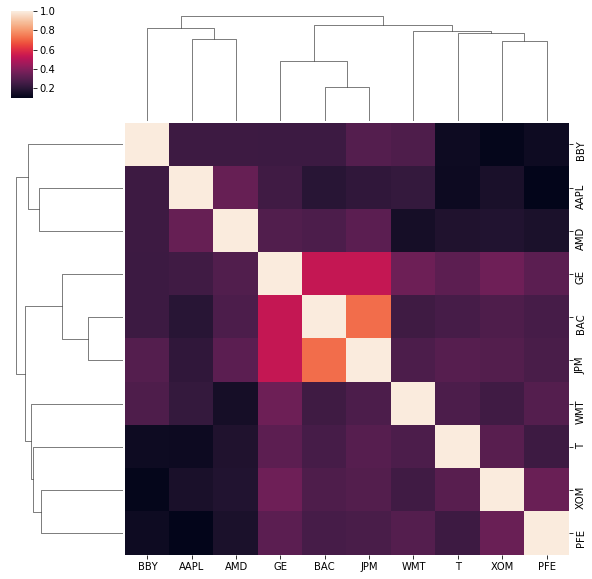

In [11]:
plt.figure(figsize=(7, 7))
sns.clustermap(stock_returns_downsampled.corr())
plt.show()

## Question-16.2

### Using the clustered covariance matrix V from exercise 1:

Each class in mlfinlab's portfolio_optimisation module has an **allocate()** method which takes the raw stock prices, calculates the returns and finds the optimal weights. There is also an option to resample the returns. For our case, we will specify 'W' for weekly resampling.

### (a) Compute the HRP allocations

In [104]:
hrp = HierarchicalRiskParity()
hrp.allocate(asset_prices = stock_prices, resample_returns_by = 'W')
hrp.weights

,BBY,AAPL,AMD,T,PFE,WMT,XOM,GE,BAC,JPM
0,0.045665,0.066572,0.035962,0.181928,0.1395,0.156088,0.23004,0.090109,0.024059,0.030077


### (b) Compute the CLA allocations

In [13]:
cla = CLA()
cla.allocate(asset_prices = stock_prices, solution = 'cla_turning_points')
cla.weights

,AAPL,GE,AMD,WMT,BAC,T,XOM,BBY,PFE,JPM
0,1.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,0.0
1,1.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,-5.684342e-14,0.000000,0.0
2,2.664535e-15,0.0,-1.776357e-15,0.0,0.0,0.000000e+00,0.0,1.000000e+00,0.000000,0.0
3,0.000000e+00,0.0,0.000000e+00,0.0,0.0,0.000000e+00,0.0,1.000000e+00,0.000000,0.0
4,0.000000e+00,0.0,5.619969e-01,0.0,0.0,0.000000e+00,0.0,4.380031e-01,0.000000,0.0
5,0.000000e+00,0.0,6.125058e-01,0.0,0.0,5.551115e-17,0.0,0.000000e+00,0.387494,0.0
6,0.000000e+00,0.0,5.920687e-01,0.0,0.0,4.079313e-01,0.0,0.000000e+00,0.000000,0.0


### Compute the IVP allocations

In [115]:
mvo = MeanVarianceOptimisation()
mvo.allocate(asset_prices = stock_prices, solution = 'inverse_variance', resample_returns_by = 'W')
mvo.weights

,AAPL,GE,AMD,WMT,BAC,T,XOM,BBY,PFE,JPM
0,0.050833,0.117737,0.024602,0.152528,0.054035,0.154546,0.224792,0.034869,0.118504,0.067553


## Question-16.3

### (a) Perform a spectral decomposition: VW=W$\wedge$

In the spectral decomposition above, **W refers to the eigenvectors matrix while $\wedge$ denotes the eigenvalues matrix - a diagonal matrix with eigenvalues along the diagonal**

In [18]:
N = stock_returns_downsampled.shape[1]

In [120]:
eigenvalues, eigenvectors = np.linalg.eig(V)
eigenvalues_matrix = np.identity(n = N) * eigenvalues
eigenvalues_matrix

array([[4.85417491e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.07330913e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.72713895e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.22346927e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        7.32009630e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

### (b) Form an array $\epsilon$ by drawing N random numbers from U[0, 1] distribution

In [24]:
epsilon = np.random.uniform(low = 0, high = 1, size = N)
epsilon

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864,
       0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258])

### (c) Form an NxN matrix $\wedge^{'}$, where $\wedge^{'}_{n,n}=N\epsilon_{n}\wedge_{n,n}(\sum\epsilon_{n})^{-1}, n=1....N$

In [25]:
eigenvalues_matrix_modified = (N * epsilon * eigenvalues_matrix)/np.sum(epsilon)

In [26]:
eigenvalues_matrix_modified

array([[3.49539481e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.78962783e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.43062096e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.40816868e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.19571392e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
   

### (d) Compute $V^{'}=W\wedge^{'}W^{-1}$

In [27]:
V_modified = eigenvectors @ eigenvalues_matrix_modified @ np.linalg.inv(eigenvectors)

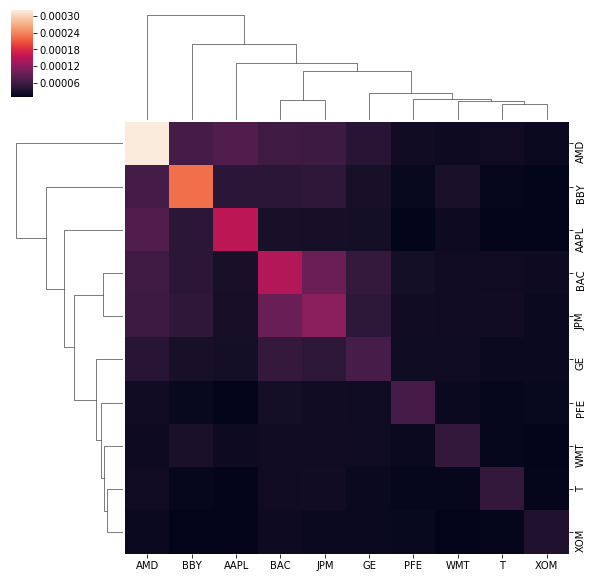

In [28]:
sns.clustermap(V)
plt.show()

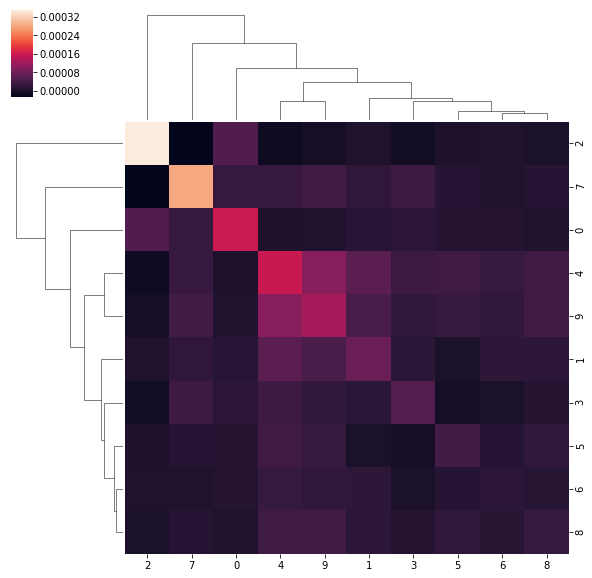

In [29]:
sns.clustermap(V_modified)
plt.show()

### (e) Repeat exercise 2, this time using $V^{'}$ as covariance matrix. What allocation method has been most impacted by the re-scaling of spectral variances?

In each of the 3 sections below, we copy the code for the three algorithms in our package. The only change is that wherever **covariance matrix is calculated from the data using asset_returns.cov(), we will use V_modified.** Everything else remains the same.

### (i) HRP

In [101]:
class HierarchicalRiskParityModified:

    def __init__(self):
        return

    def _tree_clustering(self, correlation, method='single'):
        '''
        Perform the traditional heirarchical tree clustering

        :param correlation: (np.array) correlation matrix of the assets
        :param method: (str) the type of clustering to be done
        :return: distance matrix and clusters
        '''

        distances = np.sqrt((1 - correlation) / 2)
        clusters = linkage(squareform(distances.values), method=method)
        return distances, clusters

    def _quasi_diagnalization(self, N, curr_index):
        '''
        Rearrange the assets to reorder them according to hierarchical tree clustering order.

        :param N: (int) index of element in the cluster list
        :param curr_index: (int) current index
        :return: (list) the assets rearranged according to hierarchical clustering
        '''

        if curr_index < N:
            return [curr_index]

        left = int(self.clusters[curr_index - N, 0])
        right = int(self.clusters[curr_index - N, 1])

        return (self._quasi_diagnalization(N, left) + self._quasi_diagnalization(N, right))

    def _get_seriated_matrix(self, assets, distances, correlations):
        '''
        Based on the quasi-diagnalization, reorder the original distance matrix, so that assets within
        the same cluster are grouped together.

        :param assets:
        :param distances:
        :param correlations:
        :return: (np.array) re-arranged distance matrix based on tree clusters
        '''

        ordering = assets[self.ordered_indices]
        seriated_distances = distances.loc[ordering, ordering]
        seriated_correlations = correlations.loc[ordering, ordering]
        return seriated_distances, seriated_correlations

    def _recursive_bisection(self, covariances, assets):
        '''
        Recursively assign weights to the clusters - ultimately assigning weights to the inidividual assets

        :param covariances: (np.array) the covariance matrix
        :param assets:
        '''

        self.weights = pd.Series(1, index=self.ordered_indices)
        clustered_alphas = [self.ordered_indices]

        while len(clustered_alphas) > 0:
            clustered_alphas = [cluster[start:end]
                                for cluster in clustered_alphas
                                for start, end in ((0, len(cluster) // 2), (len(cluster) // 2, len(cluster)))
                                if len(cluster) > 1]

            for subcluster in range(0, len(clustered_alphas), 2):
                left_cluster = clustered_alphas[subcluster]
                right_cluster = clustered_alphas[subcluster + 1]

                # Get left cluster variance
                left_subcovar = covariances.iloc[left_cluster, left_cluster]
                inv_diag = 1 / np.diag(left_subcovar.values)
                parity_w = inv_diag * (1 / np.sum(inv_diag))
                left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

                # Get right cluster variance
                right_subcovar = covariances.iloc[right_cluster, right_cluster]
                inv_diag = 1 / np.diag(right_subcovar.values)
                parity_w = inv_diag * (1 / np.sum(inv_diag))
                right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

                # Calculate allocation factor and weights
                alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)
                self.weights[left_cluster] *= alloc_factor
                self.weights[right_cluster] *= 1 - alloc_factor

        # Assign actual asset values to weight index
        self.weights.index = assets[self.ordered_indices]
        self.weights = pd.DataFrame(self.weights)
        self.weights = self.weights.T

    def plot_clusters(self, height=10, width=10):
        '''
        Plot a dendrogram of the hierarchical clusters

        :param height: (int) height of the plot
        :param width: (int) width of the plot
        '''

        plt.figure(figsize=(width, height))
        dendrogram(self.clusters)
        plt.show()

    def _calculate_returns(self, asset_prices, resample_returns_by):
        '''

        :param asset_prices: (pd.Dataframe/np.array) the matrix of historical asset prices (daily close)
        :param resample_returns_by: (str) specifies how to resample the returns - weekly, daily, monthly etc.. Defaults to
                                  'B' meaning daily business days which is equivalent to no resampling
        :return: (pd.Dataframe) stock returns
        '''
        asset_returns = asset_prices.pct_change()
        asset_returns = asset_returns.dropna(how='all')
        asset_returns = asset_returns.resample(resample_returns_by).mean()
        return asset_returns

    def allocate(self, asset_prices, resample_returns_by='B'):
        '''
        Calculate asset allocations using HRP algorithm

        :param asset_prices: (pd.Dataframe/np.array) the matrix of historical asset prices (daily close)
                                                     indexed by date
        :param resample_returns_by: (str) specifies how to resample the returns - weekly, daily, monthly etc.. Defaults to
                                          'B' meaning daily business days which is equivalent to no resampling
        '''

        if type(asset_prices) != pd.DataFrame:
            asset_prices = pd.DataFrame(asset_prices)

        # Calculate the returns
        asset_returns = self._calculate_returns(asset_prices, resample_returns_by=resample_returns_by)

        N = asset_returns.shape[1]
        assets = asset_returns.columns
        cov, corr = pd.DataFrame(V_modified), asset_returns.corr()

        # Step-1: Tree Clustering
        distances, self.clusters = self._tree_clustering(correlation=corr)

        # Step-2: Quasi Diagnalization
        self.ordered_indices = self._quasi_diagnalization(N, 2 * N - 2)
        self.seriated_distances, self.seriated_correlations = self._get_seriated_matrix(assets=assets,
                                                                                        distances=distances,
                                                                                        correlations=corr)

        # Step-3: Recursive Bisection
        self._recursive_bisection(covariances=cov, assets=assets)


In [103]:
hrp_modified = HierarchicalRiskParityModified()
hrp_modified.allocate(asset_prices = stock_prices, resample_returns_by = 'W')

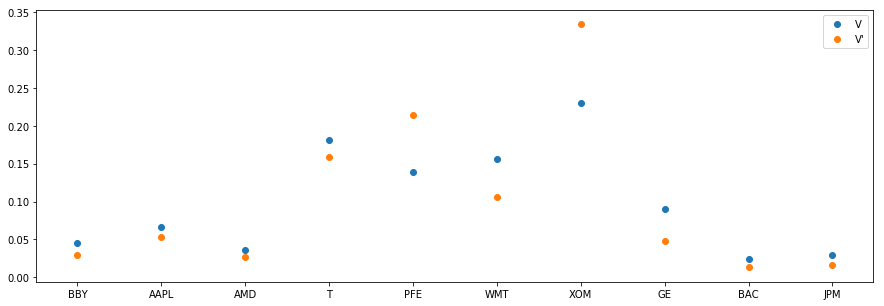

In [105]:
plt.figure(figsize = (15, 5))
plt.scatter(hrp.weights.columns, hrp.weights, label = "V")
plt.scatter(hrp_modified.weights.columns, hrp_modified.weights, label = "V'")
plt.legend()
plt.show()

Lets calculate the percentage change in the weight values

### (ii) CLA

In [107]:
def _infnone(x):
    return float("-inf") if x is None else x


class CLAModified:
    def __init__(self, weight_bounds=(0, 1), calculate_returns="mean"):
        '''
        Initialise the storage arrays and some preprocessing.

        :param weight_bounds: (tuple) a tuple specifying the lower and upper bound ranges for the portfolio weights
        :param calculate_returns: (str) the method to use for calculation of expected returns.
                                        Currently supports "mean" and "exponential"
        '''

        self.weight_bounds = weight_bounds
        self.calculate_returns = calculate_returns

    def _calculate_mean_historical_returns(self, X, frequency=252):
        '''
        Calculate the annualised mean historical returns from asset price data

        :param X: (pd.DataFrame) asset price data
        :return: (np.array) returns per asset
        '''

        returns = X.pct_change().dropna(how="all")
        returns = returns.mean() * frequency
        return returns

    def _calculate_exponential_historical_returns(self, X, frequency=252, span=500):
        '''
        Calculate the exponentially-weighted mean of (daily) historical returns, giving
        higher weight to more recent data.

        :param X: (pd.DataFrame) asset price data
        :return: (np.array) returns per asset
        '''

        returns = X.pct_change().dropna(how="all")
        returns = returns.ewm(span=span).mean().iloc[-1] * frequency
        return returns

    def _init_algo(self):
        '''
        Initial setting up of the algorithm. Calculates the first free weight of the first turning point.

        :return: (list, list) asset index and the corresponding free weight value
        '''

        # Form structured array
        structured_array = np.zeros((self.expected_returns.shape[0]), dtype=[("id", int), ("mu", float)])
        expected_returns = [self.expected_returns[i][0] for i in range(self.expected_returns.shape[0])]  # dump array into list

        # Fill structured array
        structured_array[:] = list(zip(list(range(self.expected_returns.shape[0])), expected_returns))

        # Sort structured array based on increasing return value
        expected_returns = np.sort(structured_array, order="mu")

        # First free weight
        i, w = expected_returns.shape[0], np.copy(self.lower_bounds)
        while np.sum(w) < 1:
            i -= 1

            # Set weights one by one to the upper bounds
            w[expected_returns[i][0]] = self.upper_bounds[expected_returns[i][0]]
        w[expected_returns[i][0]] += 1 - np.sum(w)
        return [expected_returns[i][0]], w

    def _compute_bi(self, c, asset_bounds_i):
        '''
        Calculates which bound value to assign to a bounded asset - lower bound or upper bound.

        :param c: (float) a value calculated using the covariance matrices of free weights.
                          Refer to https://pdfs.semanticscholar.org/4fb1/2c1129ba5389bafe47b03e595d098d0252b9.pdf for
                          more information.
        :param asset_bounds_i: (list) a list containing the lower and upper bound values for the ith weight
        :return: bounded weight value
        '''

        bounded_asset_i = 0
        if c > 0:
            bounded_asset_i = asset_bounds_i[1][0]
        if c < 0:
            bounded_asset_i = asset_bounds_i[0][0]
        return bounded_asset_i

    def _compute_w(self, covarF_inv, covar_FB, mean_F, w_B):
        '''
        Compute the turning point associated with the current set of free weights F

        :param covarF_inv: (np.array) inverse of covariance matrix of free assets
        :param covar_FB: (np.array) covariance matrix between free assets and bounded assets
        :param mean_F: (np.array) expected returns of free assets
        :param w_B: (np.array) bounded asset weight values

        :return: (array, array) list of turning point weights and gamma value from the langrange equation
        '''

        # Compute gamma
        ones_F = np.ones(mean_F.shape)
        g_1 = np.dot(np.dot(ones_F.T, covarF_inv), mean_F)
        g_2 = np.dot(np.dot(ones_F.T, covarF_inv), ones_F)
        if w_B is None:
            g, w_1 = float(-self.lambdas[-1] * g_1 / g_2 + 1 / g_2), 0
        else:
            onesB = np.ones(w_B.shape)
            g_3 = np.dot(onesB.T, w_B)
            g_4 = np.dot(covarF_inv, covar_FB)
            w_1 = np.dot(g_4, w_B)
            g_4 = np.dot(ones_F.T, w_1)
            g = float(-self.lambdas[-1] * g_1 / g_2 + (1 - g_3 + g_4) / g_2)

        # Compute weights
        w_2 = np.dot(covarF_inv, ones_F)
        w_3 = np.dot(covarF_inv, mean_F)
        return -w_1 + g * w_2 + self.lambdas[-1] * w_3, g

    def _compute_lambda(self, covarF_inv, covar_FB, mean_F, w_B, i, bi):
        '''
        Calculate the lambda value in the langrange optimsation equation

        :param covarF_inv: (np.array) inverse of covariance matrix of free assets
        :param covar_FB: (np.array) covariance matrix between free assets and bounded assets
        :param mean_F: (np.array) expected returns of free assets
        :param w_B: (np.array) bounded asset weight values
        :param i: (int) asset index
        :param bi: (list) list of upper and lower bounded weight values
        :return: (float) lambda value
        '''

        # Compute C
        ones_F = np.ones(mean_F.shape)
        c1 = np.dot(np.dot(ones_F.T, covarF_inv), ones_F)
        c2 = np.dot(covarF_inv, mean_F)
        c3 = np.dot(np.dot(ones_F.T, covarF_inv), mean_F)
        c4 = np.dot(covarF_inv, ones_F)
        c = -c1 * c2[i] + c3 * c4[i]
        if c == 0:
            return None, None

        # Compute bi
        if type(bi) == list:
            bi = self._compute_bi(c, bi)

        # Compute Lambda
        if w_B is None:

            # All free assets
            return float((c4[i] - c1 * bi) / c), bi
        else:
            onesB = np.ones(w_B.shape)
            l1 = np.dot(onesB.T, w_B)
            l2 = np.dot(covarF_inv, covar_FB)
            l3 = np.dot(l2, w_B)
            l2 = np.dot(ones_F.T, l3)
            return float(((1 - l1 + l2) * c4[i] - c1 * (bi + l3[i])) / c), bi

    def _get_matrices(self, f):
        '''
        Calculate the required matrices between free and bounded assets

        :param f: (list) list of free assets/weights
        :return: (tuple of np.array matrices) the corresponding matrices
        '''

        covarF = self._reduce_matrix(self.cov_matrix, f, f)
        mean_F = self._reduce_matrix(self.expected_returns, f, [0])
        b = self._get_b(f)
        covar_FB = self._reduce_matrix(self.cov_matrix, f, b)
        w_B = self._reduce_matrix(self.weights[-1], b, [0])
        return covarF, covar_FB, mean_F, w_B

    def _get_b(self, f):
        '''
        Compute the list of bounded assets

        :param f: (np.array) list of free weights/assets
        :return: (np.array) list of bounded assets/weights
        '''

        return self._diff_lists(list(range(self.expected_returns.shape[0])), f)

    @staticmethod
    def _diff_lists(list1, list2):
        '''
        Calculate the set difference between two lists
        '''

        return list(set(list1) - set(list2))

    @staticmethod
    def _reduce_matrix(matrix, listX, listY):
        '''
        Reduce a matrix to the provided set of rows and columns
        '''

        return matrix[np.ix_(listX, listY)]

    def _purge_num_err(self, tol):
        '''
        Purge violations of inequality constraints (associated with ill-conditioned cov matrix)
        '''

        i = 0
        while True:
            flag = False
            if i == len(self.weights):
                break
            if abs(sum(self.weights[i]) - 1) > tol:
                flag = True
            else:
                for j in range(self.weights[i].shape[0]):
                    if (
                            self.weights[i][j] - self.lower_bounds[j] < -tol
                            or self.weights[i][j] - self.upper_bounds[j] > tol
                    ):
                        flag = True
                        break
            if flag is True:
                del self.weights[i]
                del self.lambdas[i]
                del self.gammas[i]
                del self.free_weights[i]
            else:
                i += 1

    def _purge_excess(self):
        '''
        Remove violations of the convex hull
        '''

        i, repeat = 0, False
        while True:
            if repeat is False:
                i += 1
            if i == len(self.weights) - 1:
                break
            w = self.weights[i]
            mu = np.dot(w.T, self.expected_returns)[0, 0]
            j, repeat = i + 1, False
            while True:
                if j == len(self.weights):
                    break
                w = self.weights[j]
                mu_ = np.dot(w.T, self.expected_returns)[0, 0]
                if mu < mu_:
                    del self.weights[i]
                    del self.lambdas[i]
                    del self.gammas[i]
                    del self.free_weights[i]
                    repeat = True
                    break
                else:
                    j += 1

    def _golden_section(self, obj, a, b, **kargs):
        '''
        Golden section method. Maximum if kargs['minimum']==False is passed
        '''

        tol, sign, args = 1.0e-9, 1, None
        if "minimum" in kargs and kargs["minimum"] is False:
            sign = -1
        if "args" in kargs:
            args = kargs["args"]
        numIter = int(ceil(-2.078087 * log(tol / abs(b - a))))
        r = 0.618033989
        c = 1.0 - r

        # Initialize
        x1 = r * a + c * b
        x2 = c * a + r * b
        f1 = sign * obj(x1, *args)
        f2 = sign * obj(x2, *args)

        # Loop
        for i in range(numIter):
            if f1 > f2:
                a = x1
                x1 = x2
                f1 = f2
                x2 = c * a + r * b
                f2 = sign * obj(x2, *args)
            else:
                b = x2
                x2 = x1
                f2 = f1
                x1 = r * a + c * b
                f1 = sign * obj(x1, *args)
        if f1 < f2:
            return x1, sign * f1
        else:
            return x2, sign * f2

    def _eval_sr(self, a, w0, w1):
        '''
        Evaluate SR of the portfolio within the convex combination
        '''

        w = a * w0 + (1 - a) * w1
        b = np.dot(w.T, self.expected_returns)[0, 0]
        c = np.dot(np.dot(w.T, self.cov_matrix), w)[0, 0] ** 0.5
        return b / c

    def _bound_free_weight(self, free_weights):
        '''
        Add a free weight to list of bounded weights
        '''

        lambda_in = None
        i_in = None
        bi_in = None
        if len(free_weights) > 1:
            covarF, covar_FB, mean_F, w_B = self._get_matrices(free_weights)
            covarF_inv = np.linalg.inv(covarF)
            j = 0
            for i in free_weights:
                l, bi = self._compute_lambda(
                    covarF_inv, covar_FB, mean_F, w_B, j, [self.lower_bounds[i], self.upper_bounds[i]]
                )
                if _infnone(l) > _infnone(lambda_in):
                    lambda_in, i_in, bi_in = l, i, bi
                j += 1
        return lambda_in, i_in, bi_in

    def _free_bound_weight(self, free_weights):
        '''
        Add a bounded weight to list of free weights
        '''

        lambda_out = None
        i_out = None
        if len(free_weights) < self.expected_returns.shape[0]:
            b = self._get_b(free_weights)
            for i in b:
                covarF, covar_FB, mean_F, w_B = self._get_matrices(free_weights + [i])
                covarF_inv = np.linalg.inv(covarF)
                l, bi = self._compute_lambda(
                    covarF_inv,
                    covar_FB,
                    mean_F,
                    w_B,
                    mean_F.shape[0] - 1,
                    self.weights[-1][i],
                )
                if (self.lambdas[-1] is None or l < self.lambdas[-1]) and l > _infnone(lambda_out):
                    lambda_out, i_out = l, i
        return lambda_out, i_out

    def _initialise(self, asset_prices):

        # Handle non-dataframes
        if not isinstance(asset_prices, pd.DataFrame):
            asset_prices = pd.DataFrame(asset_prices)

        # Calculate the expected returns
        if self.calculate_returns == "mean":
            self.expected_returns = self._calculate_mean_historical_returns(X=asset_prices)
        else:
            self.expected_returns = self._calculate_exponential_historical_returns(X=asset_prices)
        self.expected_returns = np.array(self.expected_returns).reshape((len(self.expected_returns), 1))
        if (self.expected_returns == np.ones(self.expected_returns.shape) * self.expected_returns.mean()).all():
            self.expected_returns[-1, 0] += 1e-5

        # Calculate the covariance matrix
        self.cov_matrix = V_modified

        if isinstance(self.weight_bounds[0], numbers.Real):
            self.lower_bounds = np.ones(self.expected_returns.shape) * self.weight_bounds[0]
        else:
            self.lower_bounds = np.array(self.weight_bounds[0]).reshape(self.expected_returns.shape)

        if isinstance(self.weight_bounds[0], numbers.Real):
            self.upper_bounds = np.ones(self.expected_returns.shape) * self.weight_bounds[1]
        else:
            self.upper_bounds = np.array(self.weight_bounds[1]).reshape(self.expected_returns.shape)

        # Initialise storage buffers
        self.weights = []
        self.lambdas = []
        self.gammas = []
        self.free_weights = []

    def _max_sharpe(self):
        '''
        Compute the maximum sharpe portfolio allocation

        :return: (float, np.array) tuple of max. sharpe value and the set of weight allocations
        '''

        # 1) Compute the local max SR portfolio between any two neighbor turning points
        w_sr, sr = [], []
        for i in range(len(self.weights) - 1):
            w0 = np.copy(self.weights[i])
            w1 = np.copy(self.weights[i + 1])
            kargs = {"minimum": False, "args": (w0, w1)}
            a, b = self._golden_section(self._eval_sr, 0, 1, **kargs)
            w_sr.append(a * w0 + (1 - a) * w1)
            sr.append(b)
        return max(sr), w_sr[sr.index(max(sr))]

    def _min_volatility(self):
        '''
        Compute minimum volatility portfolio allocation

        :return: (float, np.array) tuple of minimum variance value and the set of weight allocations
        '''

        var = []
        for w in self.weights:
            a = np.dot(np.dot(w.T, self.cov_matrix), w)
            var.append(a)
        min_var = min(var)
        return min_var ** .5, self.weights[var.index(min_var)]

    def _efficient_frontier(self, points=100):
        '''
        Compute the entire efficient frontier solution

        :param points: (int) number of efficient frontier points to be calculated
        :return: tuple of mean, variance amd weights of the frontier solutions
        '''

        mu, sigma, weights = [], [], []

        # remove the 1, to avoid duplications
        a = np.linspace(0, 1, points // len(self.weights))[:-1]
        b = list(range(len(self.weights) - 1))
        for i in b:
            w0, w1 = self.weights[i], self.weights[i + 1]
            if i == b[-1]:
                # include the 1 in the last iteration
                a = np.linspace(0, 1, points // len(self.weights))
            for j in a:
                w = w1 * j + (1 - j) * w0
                weights.append(np.copy(w))
                mu.append(np.dot(w.T, self.expected_returns)[0, 0])
                sigma.append(np.dot(np.dot(w.T, self.cov_matrix), w)[0, 0] ** 0.5)
        return mu, sigma, weights

    def allocate(self, asset_prices, solution="cla_turning_points"):
        '''
        Calculate the solution of turning points satisfying the weight bounds

        :param asset_prices: (pd.Dataframe/np.array) a dataframe of historical asset prices (adj closed)
        :param solution: (str) specify the type of solution to compute. Options are: cla_turning_points, max_sharpe,
                               min_volatility, efficient_frontier
        '''

        # Some initial steps before the algorithm runs
        self._initialise(asset_prices=asset_prices)
        assets = asset_prices.columns

        # Compute the turning points,free sets and weights
        free_weights, w = self._init_algo()
        self.weights.append(np.copy(w))  # store solution
        self.lambdas.append(None)
        self.gammas.append(None)
        self.free_weights.append(free_weights[:])
        while True:

            # 1) Bound one free weight
            lambda_in, i_in, bi_in = self._bound_free_weight(free_weights)

            # 2) Free one bounded weight
            lambda_out, i_out = self._free_bound_weight(free_weights)

            if (lambda_in is None or lambda_in < 0) and (lambda_out is None or lambda_out < 0):
                # 3) Compute minimum variance solution
                self.lambdas.append(0)
                covarF, covar_FB, mean_F, w_B = self._get_matrices(free_weights)
                covarF_inv = np.linalg.inv(covarF)
                mean_F = np.zeros(mean_F.shape)
            else:
                # 4) Decide whether to free a bounded weight or bound a free weight
                if _infnone(lambda_in) > _infnone(lambda_out):
                    self.lambdas.append(lambda_in)
                    free_weights.remove(i_in)
                    w[i_in] = bi_in  # set value at the correct boundary
                else:
                    self.lambdas.append(lambda_out)
                    free_weights.append(i_out)
                covarF, covar_FB, mean_F, w_B = self._get_matrices(free_weights)
                covarF_inv = np.linalg.inv(covarF)

            # 5) Compute solution vector
            wF, g = self._compute_w(covarF_inv, covar_FB, mean_F, w_B)
            for i in range(len(free_weights)):
                w[free_weights[i]] = wF[i]
            self.weights.append(np.copy(w))  # store solution
            self.gammas.append(g)
            self.free_weights.append(free_weights[:])
            if self.lambdas[-1] == 0:
                break

        # 6) Purge turning points
        self._purge_num_err(10e-10)
        self._purge_excess()

        # Compute the specified corresponding solution
        if solution == "max_sharpe":
            self.max_sharpe, self.weights = self._max_sharpe()
            self.weights = pd.DataFrame(self.weights)
            self.weights.index = assets
            self.weights = self.weights.T
        elif solution == "min_volatility":
            self.min_var, self.weights = self._min_volatility()
            self.weights = pd.DataFrame(self.weights)
            self.weights.index = assets
            self.weights = self.weights.T
        elif solution == "efficient_frontier":
            self.mu, self.sigma, self.weights = self._efficient_frontier()
            weights_copy = self.weights.copy()
            for i, turning_point in enumerate(weights_copy):
                self.weights[i] = turning_point.reshape(1, -1)[0]
            self.weights = pd.DataFrame(self.weights, columns=assets)
        else:
            # Reshape the weight matrix
            weights_copy = self.weights.copy()
            for i, turning_point in enumerate(weights_copy):
                self.weights[i] = turning_point.reshape(1, -1)[0]
            self.weights = pd.DataFrame(self.weights, columns=assets)
            


In [108]:
cla_modified = CLAModified()
cla_modified.allocate(asset_prices = stock_prices, solution = 'cla_turning_points')

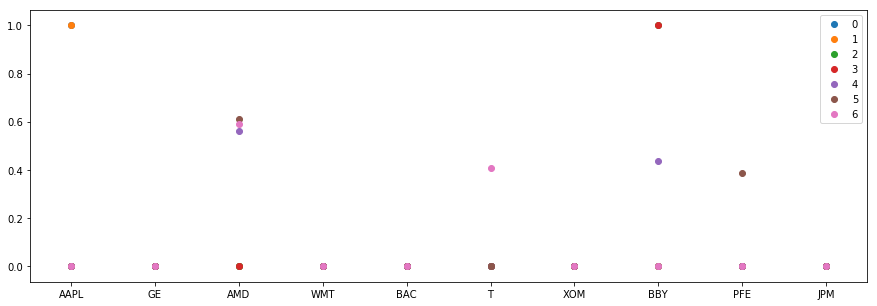

In [109]:
plt.figure(figsize = (15, 5))
for weight_index in range(cla.weights.shape[0]):
    plt.scatter(cla.weights.columns, cla.weights.iloc[weight_index, :], label = str(weight_index))
plt.legend()
plt.show()

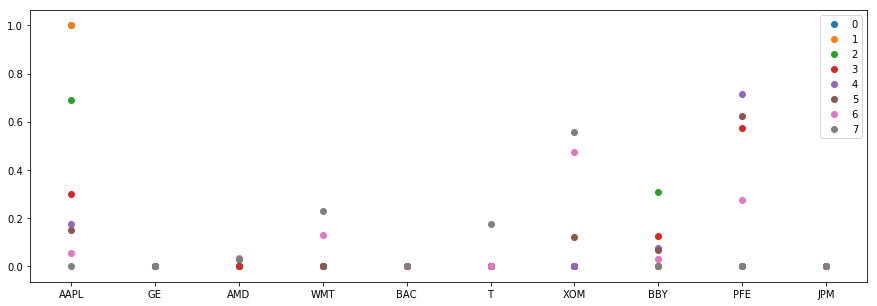

In [110]:
plt.figure(figsize = (15, 5))
for weight_index in range(cla_modified.weights.shape[0]):
    plt.scatter(cla_modified.weights.columns, cla_modified.weights.iloc[weight_index, :], label = str(weight_index))
plt.legend()
plt.show()

### (iii) IVP

In [121]:
class MeanVarianceOptimisationModified:

    def __init__(self):
        return

    def allocate(self, asset_prices, solution='inverse_variance', resample_returns_by='B'):
        '''

        :param asset_prices: (pd.Dataframe/np.array) the matrix of historical asset prices (daily close)
        :param solution: (str) the type of solution/algorithm to use to calculate the weights
        :param resample_returns_by: (str) specifies how to resample the returns - weekly, daily, monthly etc.. Defaults to
                                  'B' meaning daily business days which is equivalent to no resampling
        '''

        if not isinstance(asset_prices, pd.DataFrame):
            asset_prices = pd.DataFrame(asset_prices)

        # Calculate returns
        asset_returns = self._calculate_returns(asset_prices, resample_returns_by=resample_returns_by)
        assets = asset_prices.columns

        self.weights = []
        if solution == 'inverse_variance':
            self.weights = self._inverse_variance(asset_returns=asset_returns)
        self.weights = pd.DataFrame(self.weights)
        self.weights.index = assets
        self.weights = self.weights.T

    def _calculate_returns(self, asset_prices, resample_returns_by):
        '''

        :param asset_prices: (pd.Dataframe/np.array) the matrix of historical asset prices (daily close)
        :param resample_returns_by: (str) specifies how to resample the returns - weekly, daily, monthly etc.. Defaults to
                                  'B' meaning daily business days which is equivalent to no resampling
        :return: (pd.Dataframe) stock returns
        '''

        asset_returns = asset_prices.pct_change()
        asset_returns = asset_returns.dropna(how='all')
        asset_returns = asset_returns.resample(resample_returns_by).mean()
        return asset_returns

    def _inverse_variance(self, asset_returns):
        '''

        :param asset_prices: (pd.Dataframe/np.array) the matrix of historical asset prices (daily close)
        :return: (np.array) array of portfolio weights
        '''

        cov = pd.DataFrame(V_modified)
        ivp = 1. / np.diag(cov)
        ivp /= ivp.sum()
        return ivp

In [117]:
mvo_modified = MeanVarianceOptimisationModified()
mvo_modified.allocate(asset_prices = stock_prices, solution = 'inverse_variance', resample_returns_by = 'W')

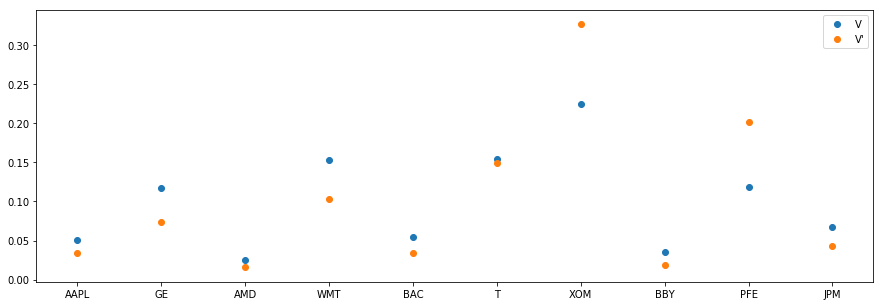

In [118]:
plt.figure(figsize = (15, 5))
plt.scatter(mvo.weights.columns, mvo.weights, label = 'V')
plt.scatter(mvo_modified.weights.columns, mvo_modified.weights, label = "V'")
plt.legend()
plt.show()